# Disaster Tweets data analysis

In [1]:
import numpy as np
import re
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
from keyword_transformer import KeywordTransformer
from location_transformer import LocationTransformer
from text_stats_transformer import TextStatsTransformer
# import spacy
# spacy.cli.download('en_core_web_sm')


In [2]:
df_train = pd.read_csv('./train_enriched.csv', index_col='id')
df_test = pd.read_csv('./test_enriched.csv', index_col='id')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7613 entries, 0 to 7612
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   keyword              7552 non-null   object 
 1   positive_factor      7613 non-null   float64
 2   location             5080 non-null   object 
 3   country              2648 non-null   object 
 4   state                1640 non-null   object 
 5   city                 1518 non-null   object 
 6   missing_location     7613 non-null   int64  
 7   text                 7613 non-null   object 
 8   clean_text           7584 non-null   object 
 9   text_content         7584 non-null   object 
 10  text_length          7613 non-null   int64  
 11  upper_text_factor    7613 non-null   float64
 12  tags_count           7613 non-null   int64  
 13  punct_factor         7613 non-null   float64
 14  ann_count            7613 non-null   int64  
 15  urls_count           7613 non-null   int64 

In [3]:
df_train.sample(n=10)

,keyword,positive_factor,location,country,state,city,missing_location,text,clean_text,text_content,...,urls_count,tokens_count,stop_words_factor,clean_tokens_factor,url_domains,url_redirects_count,hashtags_sentiment,token_sentiment,token_sentiment_2,target
id,,,,,,,,,,,,,,,,,,,,,
3470,explosion,0.512821,NaN,NaN,NaN,NaN,1,Another Mechanical Mod Explosion: Man Injured ...,another mechanical mod explosion man injured w...,Another Mechanical Mod Explosion: Man Injured ...,...,2,18,0.111111,0.777778,vaporvanity.com twitter.com,2,0.000000,1.500481,0.100032,1
6513,survive,0.156250,NaN,NaN,NaN,NaN,1,A country Chim can survive!,a country chim can survive,A country Chim can survive!,...,0,5,0.200000,0.800000,NaN,0,0.000000,0.598149,0.119630,1
6133,siren,0.125000,NaN,NaN,NaN,NaN,1,What. The. Fuck. https://t.co/Nv7rK63Pgc,what the fuck,What. The. Fuck.,...,1,4,0.000000,0.750000,NaN,0,0.000000,-0.711048,-0.237016,0
6778,tragedy,0.611111,NaN,NaN,NaN,NaN,1,Maaaaan I love Love Without Tragedy by @rihann...,maaaaan i love love without tragedy by i wish ...,Maaaaan I love Love Without Tragedy by I wish ...,...,0,15,0.200000,0.800000,NaN,0,0.000000,-5.276026,-0.376859,0
6916,trouble,0.151515,"Indiana, USA",United States,Indiana,NaN,0,@BadAstronomer ...I have a lot of trouble gett...,i have a lot of trouble getting both students ...,.I have a lot of trouble getting both students...,...,0,23,0.478261,0.521739,NaN,0,0.000000,-4.681161,-0.212780,0
265,annihilation,0.344828,Connecticut,NaN,Connecticut,NaN,0,@SonofBaldwin and he's the current Nova in the...,and hes the current nova in the bookslast i ch...,and he's the current Nova in the bookslast I c...,...,0,23,0.434783,0.565217,NaN,0,0.000000,-2.051678,-0.097699,0
2417,derailed,0.684211,"Washington, DC",United States,District of Columbia,Washington,0,#Metro still doesn't know when Blue &amp; Oran...,metro still doesnt know when blue amp orange l...,#Metro still doesn't know when Blue &amp; Oran...,...,0,24,0.166667,0.833333,NaN,0,0.555556,3.943993,0.187809,1
6714,thunderstorm,0.787879,Jupiter,NaN,NaN,NaN,0,#usNWSgov Severe Weather Statement issued Augu...,usnwsgov severe weather statement issued augus...,#usNWSgov Severe Weather Statement issued Augu...,...,1,18,0.111111,0.833333,usa.gov,1,1.000000,11.073812,0.738254,1
7147,volcano,0.666667,"West Coast, Cali USA",NaN,NaN,NaN,0,The Architect Behind Kanye WestÛªs Volcano ht...,the architect behind kanye wests volcano,The Architect Behind Kanye WestÛªs Volcano,...,1,7,0.000000,0.857143,NaN,0,0.000000,0.054774,0.009129,0


In [4]:
df_train.fillna(value={'keyword': '', 'location': '', 'clean_text': ''}, inplace=True)
df_train.sample(n=10)

,keyword,positive_factor,location,country,state,city,missing_location,text,clean_text,text_content,...,urls_count,tokens_count,stop_words_factor,clean_tokens_factor,url_domains,url_redirects_count,hashtags_sentiment,token_sentiment,token_sentiment_2,target
id,,,,,,,,,,,,,,,,,,,,,
1255,buildings%20on%20fire,0.848485,"Roanoke, VA",United States,Virginia,NaN,0,Now on WSLS: fire burns multiple buildings in ...,now on wsls fire burns multiple buildings in m...,Now on WSLS: fire burns multiple buildings in ...,...,0,21,0.142857,0.857143,NaN,0,1.000000,4.191415,0.220601,1
4661,inundated,0.171429,Pontefract UK,NaN,NaN,NaN,0,@LEDofficial1 As you can imagine we're inundat...,as you can imagine were inundated with request...,As you can imagine we're inundated with reques...,...,0,26,0.384615,0.615385,NaN,0,0.000000,-0.001746,-0.000073,1
5636,refugees,0.611111,"Bangalore, India",India,NaN,NaN,0,#Turkish couple decided to feed 4000 #Syrian #...,turkish couple decided to feed syrian refugees...,#Turkish couple decided to feed 4000 #Syrian #...,...,2,16,0.250000,0.625000,firstpost.com twitter.com,3,-0.111111,-1.938167,-0.149090,0
6095,sinking,0.195122,,NaN,NaN,NaN,1,4 equipment ego break upon dig your family int...,equipment ego break upon dig your family inter...,4 equipment ego break upon dig your family int...,...,0,16,0.125000,0.875000,NaN,0,0.000000,3.525686,0.235046,1
3313,evacuate,0.625000,Nashville,United States,Tennessee,Nashville,0,@ahhtheenikki And from what I can tell- they r...,and from what i can tell they responded to tod...,And from what I can tell- they responded to to...,...,0,26,0.500000,0.500000,NaN,0,0.000000,2.014472,0.080579,1
444,arsonist,0.235294,,NaN,NaN,NaN,1,Trusting Iran to stop terrorism is like inviti...,trusting iran to stop terrorism is like inviti...,Trusting Iran to stop terrorism is like inviti...,...,1,18,0.277778,0.666667,telegraph.co.uk,1,0.000000,-0.982382,-0.061399,0
6891,traumatised,0.057143,lowestoft,NaN,NaN,NaN,0,@vienna_butcher ITS NOT FUNNY IM TRAUMATISED,its not funny im traumatised,ITS NOT FUNNY IM TRAUMATISED,...,0,6,0.000000,1.000000,NaN,0,0.000000,-2.242160,-0.448432,0
5091,nuclear%20disaster,0.911765,Inexpressible Island,NaN,NaN,NaN,0,3 former executives to be prosecuted in Fukush...,former executives to be prosecuted in fukushim...,3 former executives to be prosecuted in Fukush...,...,1,11,0.272727,0.636364,b4in.org,1,0.000000,4.635932,0.515104,1
6489,sunk,0.230769,Wisconsin,NaN,Wisconsin,NaN,0,The courtÛªs reputation and prestige has sunk...,the courts reputation and prestige has sunk ev...,The courtÛªs reputation and prestige has sunk...,...,1,21,0.333333,0.619048,urbanmilwaukee.com,2,0.000000,-3.182849,-0.167518,0


## Features selection

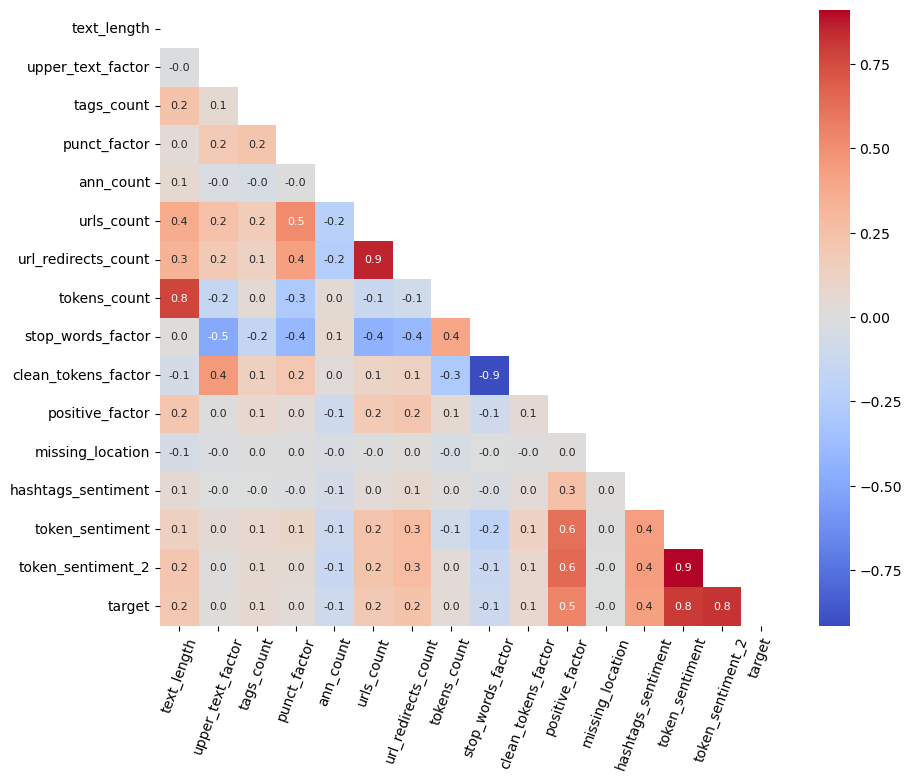

In [6]:
selected_features = ['text_length', 'upper_text_factor', 'tags_count', 'punct_factor', 'ann_count', 
                     'urls_count', 'url_redirects_count',
                     'tokens_count', 'stop_words_factor', 'clean_tokens_factor', 'positive_factor',
                     'missing_location',
                     'hashtags_sentiment', 'token_sentiment', 'token_sentiment_2',
                     'target']
df_corr = df_train[selected_features].corr()
corr_array = df_corr.to_numpy()
corr_array[np.triu_indices(len(df_corr))] = np.nan
plt.figure(figsize=(10, 8))
sns.heatmap(corr_array, annot=True, fmt=".1f", cmap='coolwarm', annot_kws={"size": 8}, xticklabels=df_corr.columns, yticklabels=df_corr.columns)
plt.xticks(rotation=70)
plt.show()